# SAM / SAMRI: Step-by-step Single-file Inference

This notebook lets you:
1. Load a **single input** file (NIfTI `.nii/.nii.gz` or standard image `.png/.jpg/.tif`).
2. Normalize like your dataset (min–max → `[0,255]`, gray→RGB), producing `H×W×3` `uint8` for SAM.
3. Register a **SAM/SAMRI** checkpoint and run inference with optional **box**/**point** prompts.
4. Visualize the image, normalized input, and predicted mask.
5. Save the predicted **mask** as `.nii.gz` (shape `1×H×W`) and an optional grayscale **PNG** (`H×W`).

> **Note:** You need the `segment_anything` package and a valid checkpoint path to run the prediction cell.

## 0. Setup
Run this cell to import dependencies and define utility functions for normalization and I/O.

In [1]:
import os
import numpy as np
import nibabel as nib
from skimage import io as skio
import matplotlib.pyplot as plt

def _to_uint8_255(arr: np.ndarray) -> np.ndarray:
    """Min-max normalize to [0,255] and cast to uint8 (robust to constant arrays)."""
    arr = np.asarray(arr)
    amin = float(arr.min())
    amax = float(arr.max())
    if amax > amin:
        out = np.rint((arr - amin) / (amax - amin) * 255.0).astype(np.uint8)
    else:
        out = np.zeros_like(arr, dtype=np.uint8)
    return out

def _ensure_hw3_from_gray(gray_hw: np.ndarray) -> np.ndarray:
    """Replicate a single-channel HxW image to HxWx3 uint8."""
    gray_hw = np.asarray(gray_hw)
    if gray_hw.ndim != 2:
        raise ValueError(f"Expected a 2D array (H,W), got shape {gray_hw.shape}.")
    return np.stack([gray_hw, gray_hw, gray_hw], axis=-1)

def _coerce_rgb_uint8(img: np.ndarray) -> np.ndarray:
    """
    Coerce HxW / HxWx1 / HxWx3 / HxWx4 into HxWx3 uint8 in [0,255],
    applying min-max normalization when needed.
    """
    img = np.asarray(img)
    if img.ndim == 3 and img.shape[-1] == 1:
        img = img[..., 0]
    if img.ndim == 2:
        return _ensure_hw3_from_gray(_to_uint8_255(img))
    if img.ndim == 3:
        if img.shape[-1] == 4:
            img = img[..., :3]  # drop alpha
        if img.shape[-1] != 3:
            raise ValueError(f"Unsupported channel count {img.shape[-1]} for image input.")
        if img.dtype != np.uint8 or img.min() < 0 or img.max() > 255:
            img = _to_uint8_255(img)
        else:
            img = img.astype(np.uint8, copy=False)
        return img
    raise ValueError(f"Unsupported image array with ndim={img.ndim}, shape={img.shape}.")

def load_file(path: str):
    """
    Load a single file (NIfTI .nii/.nii.gz OR standard image .png/.jpg/.tif),
    normalize like NiiDataset (min-max → [0,255]) and return (HxWx3) uint8.

    NIfTI:
      - Expected shape: (1,H,W) or (H,W). (H,W,1) is tolerated via squeeze.
      - Output: (H,W,3) uint8 (gray→RGB replication).
    Image:
      - Accepts HxW / HxWx1 / HxWx3 / HxWx4; coerces to HxWx3 uint8.
    """
    lower = path.lower()
    is_nii = lower.endswith('.nii') or lower.endswith('.nii.gz')

    if is_nii:
        img = nib.load(path)
        data = img.get_fdata()  # float64
        if data.ndim == 3:
            if data.shape[0] == 1:           # (1,H,W)
                sig = data[0, ...]
            else:
                if 1 in data.shape:
                    sig = np.squeeze(data)
                    if sig.ndim != 2:
                        raise ValueError(f"NIfTI squeeze did not yield 2D; got {sig.shape}.")
                else:
                    raise ValueError(f"NIfTI expected (1,H,W) or (H,W); got {data.shape}.")
        elif data.ndim == 2:
            sig = data
        else:
            raise ValueError(f"Unsupported NIfTI dimensionality {data.ndim}; need (1,H,W) or (H,W).")

        sig_u8 = _to_uint8_255(sig)
        rgb = _ensure_hw3_from_gray(sig_u8)
        info = f"NIfTI input {data.shape} → slice {sig.shape} → output {rgb.shape} (HxWxC)"
        return rgb, info

    # Standard image
    img = skio.imread(path)  # HxW / HxWx3 / HxWx4
    rgb = _coerce_rgb_uint8(img)
    info = f"Image input {np.asarray(img).shape} → output {rgb.shape} (HxWxC)"
    return rgb, info

def save_mask_nii_gz(out_dir: str, base_name: str, mask_1hw: np.ndarray, affine=None, header=None) -> str:
    """Save mask as .nii.gz with shape [1,H,W]. Uses identity affine by default."""
    os.makedirs(out_dir, exist_ok=True)
    if affine is None:
        affine = np.eye(4)
    nii = nib.Nifti1Image(mask_1hw.astype(np.uint8), affine=affine, header=header)
    out_path = os.path.join(out_dir, f"{base_name}_pred.nii.gz")
    nib.save(nii, out_path)
    return out_path

def save_mask_png(out_dir: str, base_name: str, mask_1hw: np.ndarray) -> str:
    """Save grayscale PNG (H×W) of the predicted mask (0/1 → 0/255)."""
    os.makedirs(out_dir, exist_ok=True)
    h, w = mask_1hw.shape[1], mask_1hw.shape[2]
    mask_hw = (mask_1hw.reshape(h, w).astype(np.uint8)) * 255
    out_path = os.path.join(out_dir, f"{base_name}_pred.png")
    skio.imsave(out_path, mask_hw, check_contrast=False)
    return out_path

def clean_basename(inp_path: str) -> str:
    base = os.path.basename(inp_path)
    if base.endswith('.nii.gz'):
        base = base[:-7]
    else:
        base = os.path.splitext(base)[0]
    return base


Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# ========= Point and Box Generation from the GroundTruth Utilities ===========
import random
def gen_points(mask, num_points=1):
    """
    Generate a point list [H, W] or points [[H, W], ...] in a mask.

    Parameters:
        mask (np.array): the mask in the shape of HW=(255,255) logit type
        num_points: the number of points will be generated. If the number lager
                    than 1, this function will return to a array listing all the 
                    points tuples in a list.

    Returns:
        (np.array): a [W, H] point List if the num_points = 1;
        OR
        (np.array)[[list], ...]: a list of point lists if the num_points > 1.
    """
    h, w = np.nonzero(mask)
    if num_points == 1:
        p_idx = random.randint(int(len(h)*0.45), int(len(h)*0.55))
        return np.array([[w[p_idx], h[p_idx]]])
    else:
        points = []
        for _ in range(num_points):
            p_idx = random.randint(int(len(h)*0.45), int(len(h)*0.55))
            points.append([w[p_idx], h[p_idx]])
        return np.array(points)
    
def gen_bboxes(mask, num_bboxes=1, jitter=0):
    """
    Generate a bounding box tupple with a shape of [min_w, min_h, max_w, max_h]
    or tupple list of multiple bounding boxes.

    Parameters:
        mask (np.array): the mask in the shape of HW=(255,255) logit type
        num_bboxes(Tupple): the number of bounding boxes will be generated. If 
                    the number lager than 1, this function will return to a array
                    listing all the bounding boxes tupples in a list.
        jitter (int): the random shift of the original bounding box.

    Returns:
        (list): a [min_w, min_h, max_w, max_h] bounding box list if the
                num_bboxes = 1;
        [[list], ...]: a list of bounding box lists if the num_bboxes > 1. 
    """
    h, w = np.nonzero(mask)
    bbox = [np.min(w), np.min(h), np.max(w), np.max(h)]

    if np.max(h) - np.min(h) > jitter + 10:
        bbox[1] = max(0, (np.min(h) + rand_shift(jitter)))
        bbox[3] = min(mask.shape[0], (np.max(h) + rand_shift(jitter)))
    if np.max(w) - np.min(w) > jitter + 10:
        bbox[0] = max(0, (np.min(w) + rand_shift(jitter)))
        bbox[2] = min(mask.shape[1], (np.max(w) + rand_shift(jitter)))
        
    if num_bboxes == 1:
        return np.array(bbox)
    else:
        bboxes = []
        for _ in range(num_bboxes):
            bboxes.append(bbox)
        return np.array(bboxes)

def rand_shift(jitter):
    """
    generate a random shift number from -jitter to jitter.

    Parameters:
        jitter(int): the shift number of the bbox.

    Returns:
        (int): a random shift number from -jitter to jitter
    """
    return random.randint(-jitter, jitter)

## 1. Configure paths and prompts
Set your input path, output folder, checkpoint, and optional box/point prompts here. Then run the cell.

In [3]:
# --- User configuration ---
INPUT_PATH = "/path/to/your/input.nii.gz"   # or .nii / .png / .jpg
OUTPUT_DIR = "/path/to/output_folder"
CHECKPOINT = "/path/to/your/checkpoint.pth"  # SAM / SAMRI checkpoint
MODEL_TYPE = "vit_b"  # one of: 'vit_b', 'vit_h', 'samri' (samri maps to vit_b)
DEVICE = "mps"        # 'cuda' or 'cpu' or 'mps'

# Optional prompts (pixel coords)
BOX = None             # e.g., [x1, y1, x2, y2]
POINT = None           # e.g., [x, y]
SAVE_PNG = True        # also save HxW grayscale PNG
BASE = clean_basename(INPUT_PATH)
print("Base name:", BASE)

Base name: input


In [4]:
# --- User configuration example---
INPUT_PATH = "/Volumes/MacMiniExtention/samri/Datasets/Shoulder/MSK_shoulder/training/Anon01_20120404_001_005_t2_trufi3d_we_cor_p2__1_1_img_0037.nii.gz"
OUTPUT_DIR = "/Volumes/MacMiniExtention/samri/Infer_knee"
CHECKPOINT = "/Volumes/MacMiniExtention/samri/models/samri_vitb_bp.pth"
mask, _ = load_file("/Volumes/MacMiniExtention/samri/Datasets/Shoulder/MSK_shoulder/training/Anon01_20120404_001_005_t2_trufi3d_we_cor_p2__1_1_seg_0037.nii.gz")
BOX = gen_bboxes(mask[...,0])             # e.g., [x1, y1, x2, y2]
POINT = gen_points(mask[...,0])           # e.g., [x, y]
print(BOX)
print(POINT)

[273 241 290 259]
[[284 250]]


## 2. Load input and visualize
This cell loads the file (NIfTI or image), normalizes to `H×W×3` `uint8` like your dataset, and displays it.

NIfTI input (1, 640, 640) → slice (640, 640) → output (640, 640, 3) (HxWxC)
Prepared image for SAM: (640, 640, 3) uint8


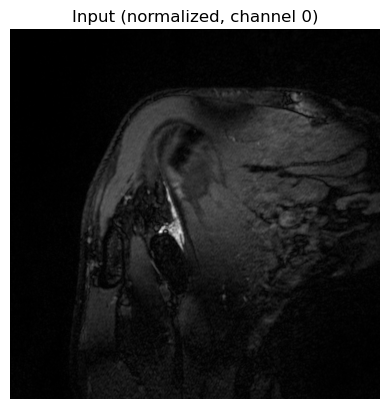

In [5]:
rgb, info = load_file(INPUT_PATH)
print(info)
print("Prepared image for SAM:", rgb.shape, rgb.dtype)

# Display the (normalized) grayscale image from channel 0
plt.figure()
plt.imshow(rgb[..., 0], cmap='gray')
plt.title('Input (normalized, channel 0)')
plt.axis('off')
plt.show()


## 3. Load model
Initialize the SAM/SAMRI model and the predictor. If the package or checkpoint are missing, you'll see a helpful error message.

In [6]:
try:
    from segment_anything import sam_model_registry, SamPredictor
except Exception as e:
    raise RuntimeError("segment_anything is not installed in this environment.") from e

def load_sam_model(checkpoint: str, model_type: str = "vit_b", device: str = "cuda"):
    key = "vit_b" if model_type.lower() in ("vit_b", "samri") else "vit_h"
    model = sam_model_registry[key](checkpoint=checkpoint)
    model = model.to(device)
    model.eval()
    return model

print("Loading model...")
model = load_sam_model(CHECKPOINT, model_type=MODEL_TYPE, device=DEVICE)
predictor = SamPredictor(model)
print("Model ready.")


Loading model...
[Warning] torch.load failed (Attempting to deserialize object on a CUDA device but torch.cuda.is_available() is False. If you are running on a CPU-only machine, please use torch.load with map_location=torch.device('cpu') to map your storages to the CPU.); retrying with map_location('mps').
Model ready.


## 4. Run prediction
This cell runs the predictor using your optional **box**/**point** prompts. If no prompts are provided, it uses a full-image box. The output mask has shape `1×H×W` (binary).

In [7]:
H, W, _ = rgb.shape
predictor.set_image(rgb)

point_coords = None
point_labels = None
if POINT is not None:
    point_coords = np.array(POINT, dtype=np.float32)
    point_labels = np.array([1], dtype=np.int32)

box_arr = None
if BOX is not None:
    box_arr = np.array(BOX, dtype=np.float32)[None, :]

pred_masks, _, _ = predictor.predict(
    point_coords=point_coords,
    point_labels=point_labels,
    box=box_arr,
    multimask_output=False,
)

if pred_masks.ndim == 2:
    pred_1hw = pred_masks[None, ...]
else:
    pred_1hw = pred_masks[:1, ...]
print("Prediction mask shape:", pred_1hw.shape, pred_1hw.dtype)


Prediction mask shape: (1, 640, 640) bool


## 5. Visualize prediction
Preview the predicted mask (grayscale), and also show a quick overlay on the input for sanity check.

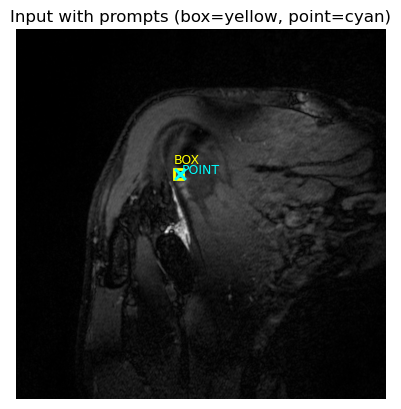

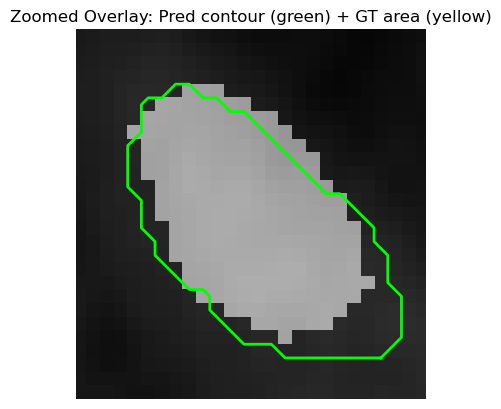

In [8]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import measure

# --- prepare arrays ---
H, W, _ = rgb.shape
pred_hw = pred_1hw.reshape(H, W).astype(bool)

# Handle ground truth
gt_hw = None
if 'mask' in globals() and mask is not None:
    gt = mask[...,0]
elif 'gt' in globals() and gt is not None:
    gt = gt
else:
    gt = None

if gt is not None:
    gt = np.asarray(gt)
    if gt.ndim == 3 and gt.shape[0] == 1:      # (1,H,W)
        gt_hw = gt[0].astype(bool)
    elif gt.ndim == 2 and gt.shape == (H, W):  # (H,W)
        gt_hw = gt.astype(bool)
    elif gt.ndim == 3 and gt.shape[-1] == 1:   # (H,W,1)
        gt_hw = gt[..., 0].astype(bool)
    else:
        print(f"[warn] GT mask has unexpected shape {gt.shape}; skipping GT overlay.")
        gt_hw = None

# ============================================================
# 1) Image with prompts (box + point)
# ============================================================
fig, ax = plt.subplots()
ax.imshow(rgb[..., 0], cmap='gray')

if 'BOX' in globals() and BOX is not None:
    x1, y1, x2, y2 = BOX
    rect = plt.Rectangle((x1, y1), x2 - x1, y2 - y1,
                         fill=False, linewidth=2, edgecolor='yellow')
    ax.add_patch(rect)
    ax.text(x1, max(0, y1 - 5), "BOX", color='yellow', fontsize=9, va='bottom')

if 'POINT' in globals() and POINT is not None:
    for i in range(len(POINT)):
        ax.scatter([POINT[i][0]], [POINT[i][1]], s=60, c='cyan', marker='x', linewidths=2)
        ax.text(POINT[i][0] + 3, POINT[i][1] + 3, "POINT", color='cyan', fontsize=9, va='bottom')

ax.set_title("Input with prompts (box=yellow, point=cyan)")
ax.axis('off')
plt.show()

# ============================================================
# 2) Overlay: predicted contour + GT yellow area (zoomed)
# ============================================================
fig, ax = plt.subplots()
ax.imshow(rgb[..., 0], cmap='gray')

# Draw ground truth area (yellow fill)
if gt is not None and gt.any():
    ax.imshow(gt, cmap='gray', alpha=0.5, interpolation='none')

# Draw predicted contour (lime)
contours = measure.find_contours(pred_hw.astype(float), level=0.5)
for c in contours:
    ax.plot(c[:, 1], c[:, 0], color='lime', linewidth=2)

# Compute zoom region based on BOX (or predicted mask if BOX is None)
if 'BOX' in globals() and BOX is not None:
    x1, y1, x2, y2 = BOX
else:
    # fallback: compute bbox from predicted mask
    ys, xs = np.nonzero(pred_hw)
    if len(xs) > 0 and len(ys) > 0:
        x1, x2 = xs.min(), xs.max()
        y1, y2 = ys.min(), ys.max()
    else:
        # fallback to full image if empty
        x1, y1, x2, y2 = 0, 0, rgb.shape[1]-1, rgb.shape[0]-1

# Expand box by 50%
expand_ratio = 0.5
w_box = x2 - x1
h_box = y2 - y1
dx = w_box * expand_ratio / 2
dy = h_box * expand_ratio / 2

x1_exp = max(0, x1 - dx)
x2_exp = min(rgb.shape[1] - 1, x2 + dx)
y1_exp = max(0, y1 - dy)
y2_exp = min(rgb.shape[0] - 1, y2 + dy)

# Apply zoom to axes
ax.set_xlim(x1_exp, x2_exp)
ax.set_ylim(y2_exp, y1_exp)  # inverted y-axis in imshow

# Add titles and aesthetics
ax.set_title("Zoomed Overlay: Pred contour (green) + GT area (yellow)")
ax.axis('off')
plt.show()



## 6. Save outputs (.nii.gz and optional PNG)
The `.nii.gz` is saved with shape `1×H×W` using an identity affine. The PNG is a single-channel grayscale image (`H×W`).

In [9]:
nii_path = save_mask_nii_gz(OUTPUT_DIR, BASE, pred_1hw, affine=np.eye(4), header=None)
print("Saved NIfTI:", nii_path)
png_path = None
if SAVE_PNG:
    png_path = save_mask_png(OUTPUT_DIR, BASE, pred_1hw)
    print("Saved PNG:", png_path)
print("Done.")


Saved NIfTI: /Volumes/MacMiniExtention/samri/Infer_knee/input_pred.nii.gz
Saved PNG: /Volumes/MacMiniExtention/samri/Infer_knee/input_pred.png
Done.
